In [3]:
pip install seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install SPARQLWrapper networkx==2.6.3 karateclub==1.3.3 matplotlib==3.8.0 --quiet

Note: you may need to restart the kernel to use updated packages.


# Open Datasets Generation for the SML task (Embeddings and Knowledge driven vectors)

This notebook contains the code to generate the open-data datasets of the Embedding and Knowledge driven Streaming machine Learning models.

Those resulting __datasets (anonymized)__, are __shared in the `opendata` folder__ of this github repo.

<img src="/img/solution_architecture.png" style="max-width: 800px;" />

<span style="color:red">
    
Due due to __confidentiality constraints__ of the power grid owner, unfortunately we cannot provide the digital twin graph and the deanonimyzed IoT stream used as a starting point for the datasets computations in this notebook.

Hence, __this notebook code can be used as a guideline to showcase the procedure steps of our approach, but cannot be executed due to the missing starting data__.
    
</span>

# Part 0: Common Code

Common code to both __1) embeddings__ and __2) KE features__ generation.

1. `generate_failure(nc_id)`: for a given _\<node_id\>_, generate a failure by switching randomically (100% - \<WGT_THRESHOLD\>) some active aconnections to inactive connections between the nodes aroud _\<node_id\>_ a at most \<HOPS_NUM\> number of hops.

2. `fix_failure(nc_id)`: for a given _\<node_id\>_, restore the normal network state switching to active connection the ones changed by the failure event.

In our experiment setting, approximately 40% of `cimext:connectedTo` properties within a 5-hop radius from the `ConnectivityNode` were randomically altered to `cimext:disconnectedFrom`.

<br>

<img src="/img/cim_extension_1.png" style="max-width: 800px;" />

<br>

<img src="/img/cim_extension_2.png" style="max-width: 800px;" />

In [2]:
from SPARQLWrapper import SPARQLWrapper, RDF, JSON
import rdflib
from rdflib import Graph
import networkx as nx
from karateclub import Graph2Vec
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import numpy as np
from SPARQLWrapper import SPARQLWrapper, RDF, JSON, TSV, POST, XML
import pandas as pd
import time
import os
import pandas as pd
import numpy as np
import os

# Set the CIM-compliant knowledge graph endpoint 
SPARQL_ENDPOINT = "http://jena:3030/brescia-network"

# Set parameters for the threshold simulation
HOPS_NUM=5
WGT_THRESHOLD=0.6

In [4]:
def generate_failure(nc_id):
    print(f"        Generating random failure(s) for node container: {nc_id}")
    
    # Update the RDF triple: set testValidation to "YES" and remove failExplaination
    update_sparql = SPARQLWrapper(SPARQL_ENDPOINT)
    
    # Q1
    update_query = f"""
    PREFIX cimext: <http://rse.it/CIM-schema-cim15-extended#>
    PREFIX cim: <http://iec.ch/TC57/2010/CIM-schema-cim15#>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    
    INSERT {{
            ?equipment cimext:faultProbability ?randWeight.
    }}
    WHERE {{
        {{
            SELECT DISTINCT ?equipment
            WHERE{{
                ?cNodeCont cim:IdentifiedObject.name '{nc_id}'.
                ?startNode cim:ConnectivityNode.ConnectivityNodeContainer ?cNodeCont.
            
                # Allow traversal up to X hops to find the target node
                ?startNode cimext:connection{{1,{HOPS_NUM}}} ?cNode2.
                FILTER(?startNode != ?cNode2)
            
                # Find all intermediate nodes in the path
                ?startNode cimext:connection{{1,{HOPS_NUM-1}}} ?cNode1.
                ?cNode1 cimext:connectedTo ?cNode2.
                FILTER(?cNode1 != ?cNode2)
            
                # Get equipment from ?cNode1 -> ?cNode2
                ?cNode1 cimext:conductingEquipment ?equipment.
                ?cNode2 cimext:conductingEquipment ?equipment.
            }}
        }}
        # Generate Fault Probability
        ?equipment a ?equipmentType.     
        FILTER (?equipmentType IN (cim:Fuse, cim:Breaker, cim:Jumper, cim:Disconnector, cim:LoadBreakSwitch))
        BIND(ROUND(RAND() * 1000) / 1000 AS ?randWeight)
    }}
    """
    update_sparql.setQuery(update_query)
    update_sparql.setMethod(POST)  # SPARQL UPDATE requires POST
    update_sparql.query()  # Execute the update
    
    ## Q2
    update_query = f"""
    PREFIX cimext: <http://rse.it/CIM-schema-cim15-extended#>
    PREFIX cim: <http://iec.ch/TC57/2010/CIM-schema-cim15#>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    
    DELETE {{
        ?cNode1 cimext:connectedTo ?cNode2.
        ?cNode2 cimext:connectedTo ?cNode1.
    }}
    INSERT {{
        ?cNode1 cimext:disconnectedFrom ?cNode2.
        ?cNode2 cimext:disconnectedFrom ?cNode1.
    }}
    WHERE {{
        {{
            SELECT DISTINCT ?cNode1 ?cNode2
            WHERE{{
                ?cNode1 a cim:ConnectivityNode.
                ?cNode2 a cim:ConnectivityNode.
            
                # Get equipment from ?cNode1 -> ?cNode2
                ?cNode1 cimext:conductingEquipment ?equipment.
                ?cNode2 cimext:conductingEquipment ?equipment.
                ?equipment cimext:faultProbability ?wgt.
                FILTER (?wgt >= {WGT_THRESHOLD})
            }}
        }}
    }}
    """
    update_sparql.setQuery(update_query)
    update_sparql.setMethod(POST)  # SPARQL UPDATE requires POST
    update_sparql.query()  # Execute the update
    
    return

def fix_failure(nc_id):
    print(f"        Fixing random failure(s) for node container: {nc_id}")
    
    # Update the RDF triple: set testValidation to "YES" and remove failExplaination
    update_sparql = SPARQLWrapper(SPARQL_ENDPOINT)
    
    ## Q1
    update_query = f"""
    PREFIX cimext: <http://rse.it/CIM-schema-cim15-extended#>
    PREFIX cim: <http://iec.ch/TC57/2010/CIM-schema-cim15#>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    
    DELETE {{
        ?cNode1 cimext:disconnectedFrom ?cNode2.
        ?cNode2 cimext:disconnectedFrom ?cNode1.
    }}
    INSERT {{
        ?cNode1 cimext:connectedTo ?cNode2.
        ?cNode2 cimext:connectedTo ?cNode1.
    }}
    WHERE {{
        {{
            SELECT DISTINCT ?cNode1 ?cNode2
            WHERE{{
                ?cNode1 a cim:ConnectivityNode.
                ?cNode2 a cim:ConnectivityNode.
            
                # Get equipment from ?cNode1 -> ?cNode2
                ?cNode1 cimext:conductingEquipment ?equipment.
                ?cNode2 cimext:conductingEquipment ?equipment.
                ?equipment cimext:faultProbability ?wgt.
                FILTER (?wgt >= {WGT_THRESHOLD})
            }}
        }}
    }}
    """
    update_sparql.setQuery(update_query)
    update_sparql.setMethod(POST)  # SPARQL UPDATE requires POST
    update_sparql.query()  # Execute the update
    
    # Q2
    update_query = f"""
    PREFIX cimext: <http://rse.it/CIM-schema-cim15-extended#>
    PREFIX cim: <http://iec.ch/TC57/2010/CIM-schema-cim15#>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    
    DELETE {{
        ?x cimext:faultProbability ?randWeight.
    }}
    WHERE {{
        ?x cimext:faultProbability ?randWeight.
    }}
    """
    update_sparql.setQuery(update_query)
    update_sparql.setMethod(POST)  # SPARQL UPDATE requires POST
    update_sparql.query()  # Execute the update
    
    return

# Part 1: Graph-Embedding Variant - Embedding Models Training

### Overview

The Graph Embedding variant, integrates real-time IoT battery sensor data with graph embeddings derived from the topology of a subset of the power grid centered on the solution.

Instead of the complex, handcrafted query, this method employs a more straightforward `SPARQL DESCRIBE` query.

### Embedding Model Training

For the training of graph embedding models,a dataset comprising roughly __15,000 power grid subgraphs__ was created. 

Half of this represents a 5-hop subgraph around each `ConnectivityNode`. The other half are negative examples obtained randomly by changing the topology around the `ConnectivityNode` at the center by operating on `ConductingEquinpment`s such as _jumpers_, _breakers_ and _fuses_.

For each `ConnectivityNode`, its corresponding 5-hop neighborhood subgraphs representing both normal conditions and negative examples were subsequently extracted utilizing the `SPARQL DESCRIBE` query in function `extract_graph_5_hop(node)`

## 1.A Retrieve node names from the network graph

Retrieve all the `ConnectivityNode`s in the Knowledge Graph (around 7,5K).

For each node, is created a __1) normal operation graph__ and a __2) negative example graph__ to train the embedding model

In [4]:
### GET NODES LIST

nodes_list = []

sparql = SPARQLWrapper(SPARQL_ENDPOINT)
sparql.setQuery("""
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX cim: <http://iec.ch/TC57/2010/CIM-schema-cim15#>
PREFIX cimext: <http://rse.it/CIM-schema-cim15-extended#>

SELECT DISTINCT ?cNodeName
WHERE {
  ?cNode a cim:ConnectivityNode; cim:IdentifiedObject.name ?cNodeName.
}
""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()
for result in results["results"]["bindings"]:
    nodes_list.append(result["cNodeName"]["value"])

## 1.B Create Negative Example Graph Knowledge Graph

Store the negative training subgraphs graph in a different digital twin graph to separate them.

In [7]:
SPARQL_ENDPOINT_GRAPH_FAIL = SPARQL_ENDPOINT+"-fails"

def generate_connection_failures():
    
    update_sparql = SPARQLWrapper(SPARQL_ENDPOINT_GRAPH_FAIL)
    
    # Q1
    update_query = f"""
    PREFIX cimext: <http://rse.it/CIM-schema-cim15-extended#>
    PREFIX cim: <http://iec.ch/TC57/2010/CIM-schema-cim15#>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    
    INSERT {{
            ?equipment cimext:faultProbability ?randWeight.
    }}
    WHERE {{
        {{
            SELECT DISTINCT ?equipment
            WHERE{{
                ?cNode a cim:ConnectivityNode.
                ?cNode cimext:conductingEquipment ?equipment.
            }}
        }}
        # Generate Fault Probability
        ?equipment a ?equipmentType.     
        FILTER (?equipmentType IN (cim:Fuse, cim:Breaker, cim:Jumper, cim:Disconnector, cim:LoadBreakSwitch))
        BIND(ROUND(RAND() * 1000) / 1000 AS ?randWeight)
    }}
    """
    update_sparql.setQuery(update_query)
    update_sparql.setMethod(POST)  # SPARQL UPDATE requires POST
    update_sparql.query()  # Execute the update
    
    ## Q2
    update_query = f"""
    PREFIX cimext: <http://rse.it/CIM-schema-cim15-extended#>
    PREFIX cim: <http://iec.ch/TC57/2010/CIM-schema-cim15#>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    
    DELETE {{
        ?cNode1 cimext:connectedTo ?cNode2.
        ?cNode2 cimext:connectedTo ?cNode1.
    }}
    INSERT {{
        ?cNode1 cimext:disconnectedFrom ?cNode2.
        ?cNode2 cimext:disconnectedFrom ?cNode1.
    }}
    WHERE {{
        {{
            SELECT DISTINCT ?cNode1 ?cNode2
            WHERE{{
                ?cNode1 a cim:ConnectivityNode.
                ?cNode2 a cim:ConnectivityNode.
            
                # Get equipment from ?cNode1 -> ?cNode2
                ?cNode1 cimext:conductingEquipment ?equipment.
                ?cNode2 cimext:conductingEquipment ?equipment.
                ?equipment cimext:faultProbability ?wgt.
                FILTER (?wgt >= {WGT_THRESHOLD})
            }}
        }}
    }}
    """
    update_sparql.setQuery(update_query)
    update_sparql.setMethod(POST)  # SPARQL UPDATE requires POST
    update_sparql.query()  # Execute the update
    
    return

generate_connection_failures()

## 1.C Create Subgraphs for Embedding Model Training

Here, we define the `SPARQL DESCRIBE` query to extract the training subgraphs (around 15K)

Training set composition:
- 50% situations: subgraphs representing normal working situations, from the digital twin graph
- 50% situations: subgraphs representing anomalous working situations, from the negative digital twin graph

In [ ]:
graph_list_train = []

def extract_graph_5_hop(node):
    return """
    PREFIX cimext: <http://rse.it/CIM-schema-cim15-extended#>
    PREFIX cim: <http://iec.ch/TC57/2010/CIM-schema-cim15#>
    
    # Find all nodes up to 5 hops
    DESCRIBE ?node ?usagePoint
    WHERE {
      ?startNode a cim:ConnectivityNode;
             cim:IdentifiedObject.name '"""+node+"""'.
             
      ?startNode cimext:connection{0,5} ?node.
      
      # Check if the node has a usage point
      OPTIONAL {
        ?node cimext:usagePoint ?usagePoint .
      }
    }
    """

def generate_graph_data(node, fail_graph=False):
    # Initialize SPARQL query
    if fail_graph==False:
        sparql = SPARQLWrapper(SPARQL_ENDPOINT)
    else:
        sparql = SPARQLWrapper(SPARQL_ENDPOINT_GRAPH_FAIL)    
    sparql.setQuery(extract_graph_5_hop(node))
    # Set return format to RDF/XML
    sparql.setReturnFormat('rdf/xml')
    sparql.addCustomHttpHeader("Accept", "application/rdf+xml")
    
    # Execute the query
    results = sparql.query().convert()
    serialized_results = results.serialize(format="xml")
    
    # Load results into an RDFLib Graph
    rdf_graph = Graph()
    rdf_graph.parse(data=serialized_results, format="xml")  # Adjust format based on SPARQLWrapper return
    
    # Initialize a NetworkX graph
    G = nx.Graph()
    
    # Add edges and nodes from RDF data
    for s, p, o in rdf_graph:
        G.add_edge(str(s), str(o), predicate=str(p))
    
    # Relabel Nodes to Integers
    G = nx.convert_node_labels_to_integers(G, label_attribute="original_label")
    
    return G

x = 0

for node in nodes_list:    
    # Case 1: no failures
    G1=generate_graph_data(node, False)
    
    # Case: random failures
    G2=generate_graph_data(node, True)

    # Append the graphs to the list
    graph_list_train.append(G1)
    graph_list_train.append(G2)
    
    if x%100==0:
        print(x)
    x = x+1

In [11]:
#import pickle
#
## Save the list to a file
#with open('graph_list_embeddings_training_5hop.pkl', 'wb') as file:
#    pickle.dump(graph_list_train, file)

In [18]:
## Load the list to a file
#import pickle
#
#with open('graph_list_embeddings_training_5hop.pkl', 'rb') as file:
#    graph_list_train = pickle.load(file)

In [19]:
len(graph_list_train)

15242

## 1.D Compute Embedding Models (Graph2Vec - KarateClub)

With approximately 7,500 subgraphs per condition, we trained multiple embedding models using Graph2Vec. 

This involved exploring various hyperparameter combinations, including:
- Weisfeiler-Lehman (WL) iterations (2 or 3)
- embedding dimensions (8 or 16)
- training epochs (from 10 to 300)

In [ ]:
import time
import csv
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

DIM_OPTIONS = [8, 16]
WL_OPTIONS = [2, 3]
EPOCH_LIST = [10, 50, 100, 150, 200, 300]

csv_file = "graph2vec_training_times.csv"
write_header = not os.path.exists(csv_file)  # Check if file exists

with open(csv_file, mode='a', newline='') as f:
    writer = csv.writer(f)

    if write_header:
        writer.writerow(["dimensions", "wl_iterations", "epochs", "training_time_sec"])

    for dim in DIM_OPTIONS:
        for wl in WL_OPTIONS:
            for epochs in EPOCH_LIST:
                print(f"Training: dim={dim}, wl={wl}, epochs={epochs}")

                start_time = time.time()

                model = Graph2Vec(dimensions=dim, wl_iterations=wl, workers=4, epochs=epochs)
                model.fit(graph_list_train)
                embeddings = model.get_embedding()

                elapsed_time = round(time.time() - start_time, 2)

                # Write result immediately
                writer.writerow([dim, wl, epochs, elapsed_time])

                print(f"Completed in {elapsed_time:.2f} seconds.\n")
                
                # Save the model into a file
                with open(f"embedding_model_5hop_wl_{wl}_epochs_{epochs}_{dim}.pkl", "wb") as f:
                    pickle.dump(model_10, f)

print(f"Training times appended to '{csv_file}'")

Here we compare training times to check if the problem is linear ...

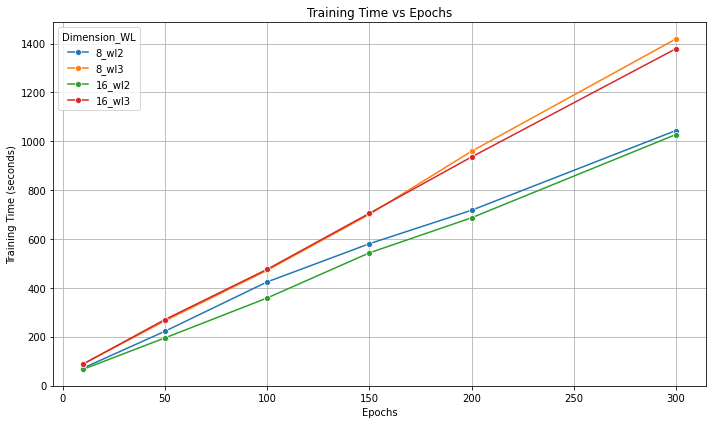

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read data from CSV file
df = pd.read_csv(csv_file)

# Create a new column for grouping based on dimensions and wl_iterations
df['config'] = df['dimensions'].astype(str) + "_wl" + df['wl_iterations'].astype(str)

# Plotting
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='epochs', y='training_time_sec', hue='config', marker="o")
plt.title('Training Time vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Time (seconds)')
plt.grid(True)
plt.legend(title='Dimension_WL')
plt.tight_layout()

# Save the plot as an image file
plt.savefig('embedding_models_training_times.png')


# Part 2: Knowledge-Driven Variant

The KE-driven variant use scenario, integrates battery sensor stream data (IoT) with contextual information from the digital twin graph, extracted using a SPARQL analytical query designed by the Knowledge Engineer with the help of a domain expert.

The query in function `get_ke_features(nc_id)` retrieves, for a given substation `ConnectivityNode`, identified by a _\<NODE-ID\>_ from the battery stream, the connected `ConnectivityNode`s neighbors up to 5 hops through the cimext:connectedTo
property.
    
From this subgraph, it extracts associated `UsagePoint`s and their power consumption metrics (active power `p` and reactive power `q`).
    
These data is then aggregated into a feature vector, including:
- ___count of unique UsagePoints___ (`cntUp`)
- ___total active power___ (`pTot`)
- ___total reactive power___ (`qTot`)
- ___count of distinct load groups___ (`loadGroups`)
- ___count of distinct service locations___ (`serviceLocations`).

In [5]:
def get_ke_features(nc_id):
    sparql = SPARQLWrapper(SPARQL_ENDPOINT)
    
    query = f"""
    PREFIX cimext: <http://rse.it/CIM-schema-cim15-extended#>
    PREFIX cim: <http://iec.ch/TC57/2010/CIM-schema-cim15#>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    
    SELECT (COUNT(?usagePoint) AS ?cntUp) (SUM(?P) AS ?pTot) (SUM(?Q) AS ?qTot) (COUNT(DISTINCT ?lt) AS ?loadGroups) (COUNT(DISTINCT ?sl) AS ?serviceLocations)
    WHERE {{
      SELECT DISTINCT ?usagePoint ?P ?Q ?lt ?sl
      WHERE{{
        ?cNodeCont cim:IdentifiedObject.name '{nc_id}'.
        ?cNode1 cim:ConnectivityNode.ConnectivityNodeContainer ?cNodeCont.
        OPTIONAL{{
            ?cNode1 cimext:usagePoint ?usagePoint.
            ?usagePoint cim:UsagePoint.p ?p; cim:UsagePoint.q ?q; cim:UsagePoint.loadGroup ?lt; cim:UsagePoint.ServiceLocation ?sl.
        }}
    
        # Optional hop 1
        OPTIONAL {{
            ?cNode1 cimext:connectedTo ?cNode2.
            OPTIONAL{{
                ?cNode2 cimext:usagePoint ?usagePoint.
                ?usagePoint cim:UsagePoint.p ?p; cim:UsagePoint.q ?q; cim:UsagePoint.loadGroup ?lt; cim:UsagePoint.ServiceLocation ?sl.
            }}
    
            # Optional hop 2
            OPTIONAL {{
                ?cNode2 cimext:connectedTo ?cNode3.
                OPTIONAL{{
                    ?cNode3 cimext:usagePoint ?usagePoint.
                    ?usagePoint cim:UsagePoint.p ?p; cim:UsagePoint.q ?q; cim:UsagePoint.loadGroup ?lt; cim:UsagePoint.ServiceLocation ?sl.
                }}
    
                # Optional hop 3
                OPTIONAL {{
                    ?cNode3 cimext:connectedTo ?cNode4.
                    OPTIONAL{{
                        ?cNode4 cimext:usagePoint ?usagePoint.
                        ?usagePoint cim:UsagePoint.p ?p; cim:UsagePoint.q ?q; cim:UsagePoint.loadGroup ?lt; cim:UsagePoint.ServiceLocation ?sl.
                    }}
            
                    # Optional hop 4
                    OPTIONAL {{
                        ?cNode4 cimext:connectedTo ?cNode5.
                        OPTIONAL{{
                            ?cNode5 cimext:usagePoint ?usagePoint.
                            ?usagePoint cim:UsagePoint.p ?p; cim:UsagePoint.q ?q; cim:UsagePoint.loadGroup ?lt; cim:UsagePoint.ServiceLocation ?sl.
                        }}
                        
                        # Optional hop 5
                        OPTIONAL {{
                            ?cNode5 cimext:connectedTo ?cNode6.
                            OPTIONAL{{
                                ?cNode6 cimext:usagePoint ?usagePoint.
                                ?usagePoint cim:UsagePoint.p ?p; cim:UsagePoint.q ?q; cim:UsagePoint.loadGroup ?lt; cim:UsagePoint.ServiceLocation ?sl.
                            }}
                        }}
                    }}
                }}
            }}
        }}
        
        BIND(xsd:float(COALESCE(?p, 0)) AS ?P)
        BIND(xsd:float(COALESCE(?q, 0)) AS ?Q)
      }}
    }}
    GROUP BY ?type
    """
    
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    # Extract values
    result_dict = {"cntUp": 0, "pTot": 0.0, "qTot": 0.0, "loadGroups":0, "serviceLocations": 0}

    for result in results["results"]["bindings"]:
        result_dict["cntUp"] = int(result["cntUp"]["value"]) if "cntUp" in result else 0
        result_dict["pTot"] = float(result["pTot"]["value"]) if "pTot" in result else 0.0
        result_dict["qTot"] = float(result["qTot"]["value"]) if "qTot" in result else 0.0
        result_dict["loadGroups"] = int(result["loadGroups"]["value"]) if "loadGroups" in result else 0
        result_dict["serviceLocations"] = int(result["serviceLocations"]["value"]) if "serviceLocations" in result else 0

    return result_dict

Here we are testing the feature vector generation for a roandom anomalous event:

In [5]:
get_ke_features("CABIN-0001")

{'cntUp': 160,
 'pTot': 41264.086,
 'qTot': 13944.176,
 'loadGroups': 73,
 'serviceLocations': 33}

In [8]:
generate_failure("CABIN-0001")

        Generating random failure(s) for node container: CABIN-0001


In [9]:
get_ke_features("CABIN-0001")

{'cntUp': 130,
 'pTot': 34785.15,
 'qTot': 12055.4,
 'loadGroups': 66,
 'serviceLocations': 26}

In [10]:
fix_failure("CABIN-0001")

        Fixing random failure(s) for node container: CABIN-0001


In [11]:
get_ke_features("CABIN-0001")

{'cntUp': 160,
 'pTot': 41264.086,
 'qTot': 13944.176,
 'loadGroups': 73,
 'serviceLocations': 33}

# Part 3: Compute Graph Embeddings and KE Features

In this section, we use both the embedding models and the ke-driven variant code to create the open datasets that we published with out paper.

To label events as anomalous, for each outlier identified, we randomly change the power grid topology around the substation (e.g., opening a switch or operating  a braker) and extract the features from the digital twin. An event was finally
labeled as anomalous only if, in addition to being an outlier in the stream, it showed a relative change of at least 25%, compared to its immediately preceding value, in at least one of the following semantic features: number of utilization
points, pTot, or qTot. Straight after the event preprocessing, the power grid is set back to its original topology.

This approach, combining statistical signals and semantic features affected by topological transitions of the pwoer grid, ensures that the ground truth reflects indicators of anomalous behavior at both the sensor and domain levels. Features such as service location and load group were excluded from this decision rule.

This methodology resulted in approximately 5% of the data per substation being labeled anomalous, with a consistent distribution across the entire dataset. Therefore, the resulting dataset is significantly skewed, with 623 events out of
12.908 labeled anomalous.

In [7]:
# Load saved embedding models

import pickle

# Load the model from a file
with open("embedding_model_5hop_wl_2_epochs_50_8.pkl", "rb") as f:
    wl_2_epochs_50_8 = pickle.load(f)
    
# Load the model from a file
with open("embedding_model_5hop_wl_3_epochs_50_8.pkl", "rb") as f:
    wl_3_epochs_50_8 = pickle.load(f)
    
# Load the model from a file
with open("embedding_model_5hop_wl_2_epochs_50_16.pkl", "rb") as f:
    wl_2_epochs_50_16 = pickle.load(f)
    
# Load the model from a file
with open("embedding_model_5hop_wl_3_epochs_50_16.pkl", "rb") as f:
    wl_3_epochs_50_16 = pickle.load(f)

# Load the model from a file
with open("embedding_model_5hop_wl_2_epochs_200_8.pkl", "rb") as f:
    wl_2_epochs_200_8 = pickle.load(f)
    
# Load the model from a file
with open("embedding_model_5hop_wl_3_epochs_200_8.pkl", "rb") as f:
    wl_3_epochs_200_8 = pickle.load(f)
    
# Load the model from a file
with open("embedding_model_5hop_wl_2_epochs_200_16.pkl", "rb") as f:
    wl_2_epochs_200_16 = pickle.load(f)
    
# Load the model from a file
with open("embedding_model_5hop_wl_3_epochs_200_16.pkl", "rb") as f:
    wl_3_epochs_200_16 = pickle.load(f)
    
# Load the model from a file
with open("embedding_model_5hop_wl_2_epochs_300_8.pkl", "rb") as f:
    wl_2_epochs_300_8 = pickle.load(f)
    
# Load the model from a file
with open("embedding_model_5hop_wl_3_epochs_300_8.pkl", "rb") as f:
    wl_3_epochs_300_8 = pickle.load(f)
    
# Load the model from a file
with open("embedding_model_5hop_wl_2_epochs_300_16.pkl", "rb") as f:
    wl_2_epochs_300_16 = pickle.load(f)
    
# Load the model from a file
with open("embedding_model_5hop_wl_3_epochs_300_16.pkl", "rb") as f:
    wl_3_epochs_300_16 = pickle.load(f)
    

# Define all models in array
models = [
    wl_2_epochs_50_8,
    wl_3_epochs_50_8,
    wl_2_epochs_50_16,
    wl_3_epochs_50_16,
    wl_2_epochs_200_8,
    wl_3_epochs_200_8,
    wl_2_epochs_200_16,
    wl_3_epochs_200_16,
    wl_2_epochs_300_8,
    wl_3_epochs_300_8,
    wl_2_epochs_300_16,
    wl_3_epochs_300_16,
]

# Corresponding names
model_names = [
    "wl_2_epochs_50_8",
    "wl_3_epochs_50_8",
    "wl_2_epochs_50_16",
    "wl_3_epochs_50_16",
    "wl_2_epochs_200_8",
    "wl_3_epochs_200_8",
    "wl_2_epochs_200_16",
    "wl_3_epochs_200_16",
    "wl_2_epochs_300_8",
    "wl_3_epochs_300_8",
    "wl_2_epochs_300_16",
    "wl_3_epochs_300_16",
]

In [ ]:
# Simulation code to generate the open-data dataset

import os
import pandas as pd
import numpy as np
import networkx as nx
from rdflib import Graph
from SPARQLWrapper import SPARQLWrapper

# --- SPARQL Query ---
def embedding_query(nodeContainer):
    return f"""
    PREFIX cimext: <http://rse.it/CIM-schema-cim15-extended#>
    PREFIX cim: <http://iec.ch/TC57/2010/CIM-schema-cim15#>
    DESCRIBE ?node ?usagePoint
    WHERE {{
      ?cNodeCont cim:IdentifiedObject.name '{nodeContainer}'.
      ?startNode cim:ConnectivityNode.ConnectivityNodeContainer ?cNodeCont .
      ?startNode cimext:connection{{0,5}} ?node.
      OPTIONAL {{ ?node cimext:usagePoint ?usagePoint . }}
    }}
    """

# --- Generate Embeddings ---
def generate_embedding(nodeContainer, model):
    sparql = SPARQLWrapper(SPARQL_ENDPOINT)
    sparql.setQuery(embedding_query(nodeContainer))
    sparql.setReturnFormat('rdf/xml')
    sparql.addCustomHttpHeader("Accept", "application/rdf+xml")
    
    results = sparql.query().convert()
    serialized_results = results.serialize(format="xml")

    rdf_graph = Graph()
    rdf_graph.parse(data=serialized_results, format="xml")

    G = nx.Graph()
    for s, p, o in rdf_graph:
        G.add_edge(str(s), str(o), predicate=str(p))

    G = nx.convert_node_labels_to_integers(G, label_attribute="original_label")
    embedding = model.infer([G])
    return embedding

# --- Dump Graph ---
def dump_graph_data(nc_id, ts, path_graphs, fail=False):
    sparql = SPARQLWrapper(SPARQL_ENDPOINT)
    sparql.setQuery(embedding_query(nc_id))
    sparql.setReturnFormat('rdf/xml')
    response = sparql.query().response

    dir_path = os.path.join(path_graphs, "failures" if fail else "no_failures")
    os.makedirs(dir_path, exist_ok=True)

    file_name = f"{ts.replace(' ', 'T')}__{nc_id}.xml" if fail else f"{nc_id}.xml"
    print(f"  Dumping graph export into: {os.path.join(dir_path, file_name)}")
    with open(os.path.join(dir_path, file_name), "wb") as f:
        f.write(response.read())

# --- Format Embedding ---
def format_embedding(embedding):
    if embedding is None:
        return ""
    return "[" + ", ".join(map(str, np.array(embedding).flatten())) + "]"

import os
import pandas as pd

# --- Load Input CSV with IoT data stream ---
df = pd.read_csv("stream_with_anomalies_and_targets.csv", header=0)

# --- Paths and Output to save the open-data dataset ---
PATH_GRAPHS = "./extracted_graphs"
OUTPUT_FILE = "ke_and_embeddings_data.csv"

print(f"\n=== Processing for models: {model_names} ===")

if os.path.exists(OUTPUT_FILE):
    os.remove(OUTPUT_FILE)

cached_target_features = {}       # key: substation_id
cached_target_embeddings = {}     # key: substation_id_modelname

nc_id_prev_fail = ""
time_event = 0

for index, row in df.iterrows():
    if nc_id_prev_fail:
        fix_failure(nc_id_prev_fail)
        nc_id_prev_fail = ""

    print("event:", time_event)
    print(f"  Time: {row['Timestamp']}     Substation_ID: {row['Substation_ID']}      anomaly: {row['Anomaly']}     target: {row['Target']}")

    substation_id = row['Substation_ID']
    sub_key = substation_id  # used for caching features

    anomaly_features = None
    target_features = None
    anomaly_embeddings = []
    target_embeddings = []

    # --- Target == 0 ---
    if row['Target'] == 0:
        if sub_key not in cached_target_features:
            target_features = get_ke_features(substation_id)
            cached_target_features[sub_key] = target_features

            for i, model in enumerate(models):
                embedding = generate_embedding(substation_id, model)
                target_embeddings.append(embedding)
                cached_target_embeddings[f"{sub_key}_{model_names[i]}"] = embedding

            dump_graph_data(substation_id, row['Timestamp'], PATH_GRAPHS, fail=False)
        else:
            target_features = cached_target_features[sub_key]
            for i, model in enumerate(models):
                print(f"  Target embeddings from cache for {model_names[i]}")
                target_embeddings.append(cached_target_embeddings[f"{sub_key}_{model_names[i]}"])

    # --- Anomaly == 1 ---
    if row['Anomaly'] == 1:
        generate_failure(substation_id)
        dump_graph_data(substation_id, row['Timestamp'], PATH_GRAPHS, fail=True)

        nc_id_prev_fail = substation_id
        anomaly_features = get_ke_features(substation_id)

        for model in models:
            anomaly_embeddings.append(generate_embedding(substation_id, model))

        if row['Target'] == 1:
            target_features = anomaly_features
            target_embeddings = anomaly_embeddings.copy()

    # --- Anomaly == 0 ---
    elif row['Anomaly'] == 0:
        if sub_key not in cached_target_features:
            anomaly_features = get_ke_features(substation_id)
            cached_target_features[sub_key] = anomaly_features

            for i, model in enumerate(models):
                embedding = generate_embedding(substation_id, model)
                anomaly_embeddings.append(embedding)
                cached_target_embeddings[f"{sub_key}_{model_names[i]}"] = embedding

            dump_graph_data(substation_id, row['Timestamp'], PATH_GRAPHS, fail=False)
        else:
            anomaly_features = cached_target_features[sub_key]
            for i, model in enumerate(models):
                print(f"  Anomaly embeddings from cache for {model_names[i]}")
                anomaly_embeddings.append(cached_target_embeddings[f"{sub_key}_{model_names[i]}"])

        if row['Target'] == 1:
            generate_failure(substation_id)
            dump_graph_data(substation_id, row['Timestamp'], PATH_GRAPHS, fail=True)
            nc_id_prev_fail = substation_id

            target_features = get_ke_features(substation_id)
            for model in models:
                target_embeddings.append(generate_embedding(substation_id, model))

    print("  Target Features:", target_features)
    print("  Anomaly Features:", anomaly_features)
    print("  Target Embeddings:", target_embeddings)
    print("  Anomaly Embeddings:", anomaly_embeddings)

    # --- Save Row ---
    row_data = {
        "Timestamp": row['Timestamp'],
        "Substation_ID": substation_id,
        "Anomaly": row['Anomaly'],
        "Target": row['Target'],
        "Features_Anomaly": anomaly_features,
        "Features_Target": target_features,
    }

    # Add embeddings per model
    for i, model_name in enumerate(model_names):
        row_data[f"Embeddings_Anomaly_{model_name}"] = format_embedding(anomaly_embeddings[i]) if i < len(anomaly_embeddings) else None
        row_data[f"Embeddings_Target_{model_name}"] = format_embedding(target_embeddings[i]) if i < len(target_embeddings) else None

    df_out = pd.DataFrame([row_data])
    df_out.to_csv(OUTPUT_FILE, mode='a', header=not os.path.exists(OUTPUT_FILE), index=False)

    time_event += 1
